In [1]:
import pandas as pd
from DeepRetail.data.dataloader import Reader
from DeepRetail.transformations.formats import transaction_df
from DeepRetail.forecasting.statistical import StatisticalForecaster

/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Load
df = pd.read_csv('/home/filtheo/DeepRetail/DeepRetail/data/data_folder/m5_day.csv', index_col=0)
df.head()

,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
unique_id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [3]:
# get a sample 
sampled_df = df.sample(20)
sampled_df.head()

,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
unique_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_042_TX_2,0,0,0,0,0,0,0,0,0,0,...,5,10,2,2,4,5,3,12,0,0
FOODS_3_207_TX_3,5,3,1,0,0,2,1,1,1,1,...,0,0,6,0,0,0,0,0,2,0
FOODS_2_201_CA_4,0,0,0,0,0,0,0,0,0,0,...,3,1,0,1,2,2,0,1,4,3
HOUSEHOLD_1_483_CA_2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,2,0,0,2
HOUSEHOLD_2_027_CA_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Will use statsforecast!!
from statsforecast import StatsForecast
from statsforecast.models import AutoETS, AutoARIMA, Naive, SeasonalNaive
import numpy as np
import warnings
from DeepRetail.forecasting.utils import get_numeric_frequency
from DeepRetail.transformations.formats import sktime_forecast_format, transaction_df
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.stattools import acf


In [5]:
# convert to transaction
t_df = transaction_df(sampled_df)

In [6]:
# Define the parameters
freq = 'M'
h = 4
holdout = True
cv = 2
models = ['ETS', 'Naive']

In [7]:
# Convert columns to datetime
sampled_df.columns = pd.to_datetime(sampled_df.columns)

# Resample columns to montly frequency
sampled_df = sampled_df.resample('M', axis=1).sum()

In [8]:
# Define the forecaster
forecaster = StatisticalForecaster(models = models, freq = freq)

# Fit the forecaster
forecaster.fit(sampled_df, format = 'pivoted')

# predict
forecast_df = forecaster.predict(h = h, cv = cv, holdout = holdout)

In [9]:
forecast_df.head()

,unique_id,date,cutoff,True,Model,y,fh,cv
0,FOODS_1_042_TX_2,2015-12-31,2015-11-30,144.0,Naive,142.0,1,1
1,FOODS_1_042_TX_2,2016-01-31,2015-11-30,106.0,Naive,142.0,2,1
2,FOODS_1_042_TX_2,2016-02-29,2015-11-30,150.0,Naive,142.0,3,1
3,FOODS_1_042_TX_2,2016-03-31,2015-11-30,157.0,Naive,142.0,4,1
4,FOODS_1_042_TX_2,2016-01-31,2015-12-31,106.0,Naive,144.0,2,2


In [84]:
residuals = forecaster.calculate_residuals()

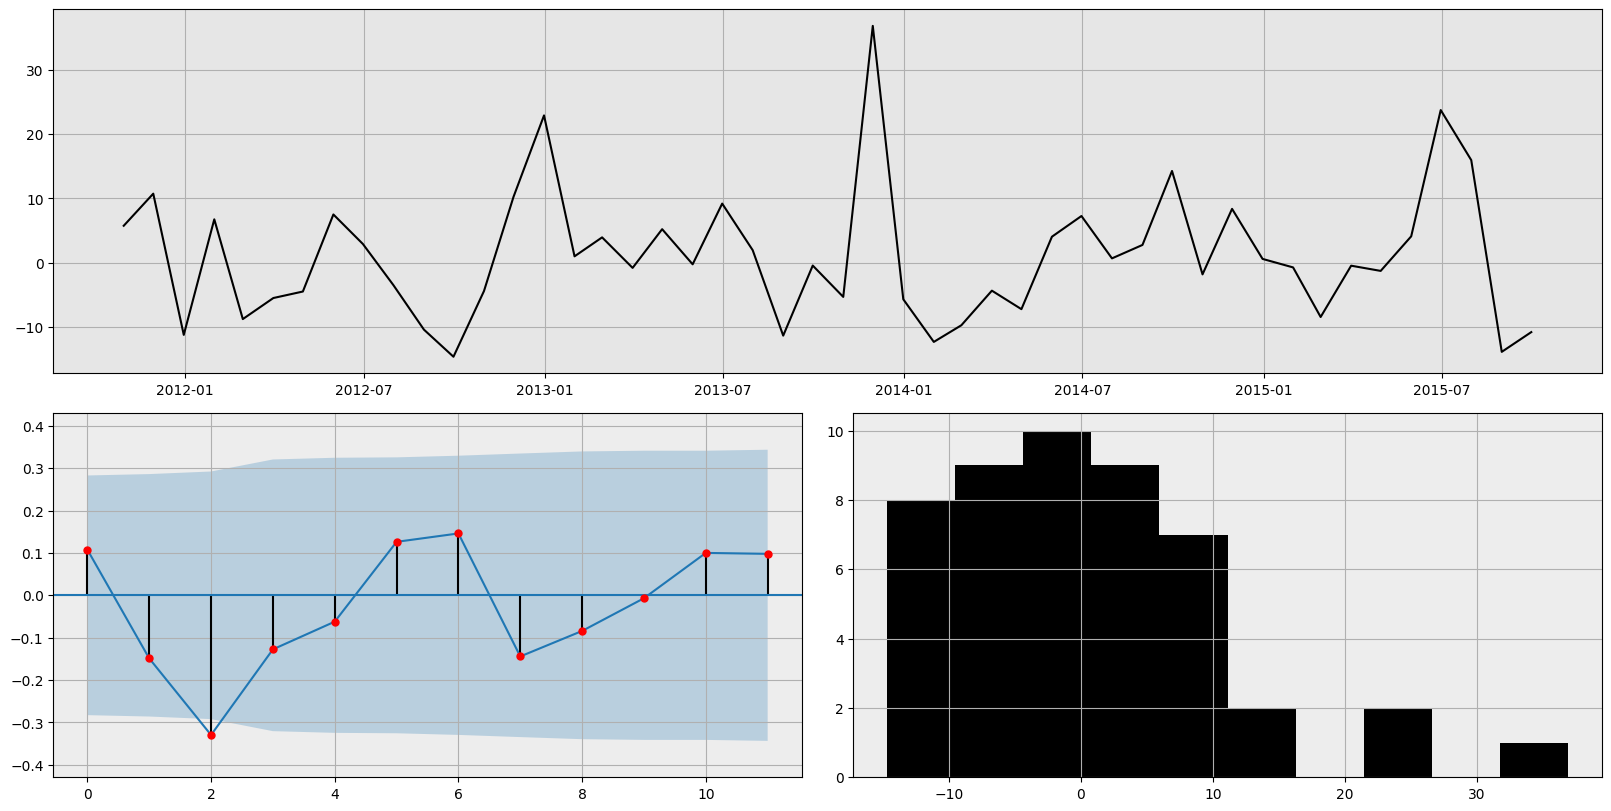

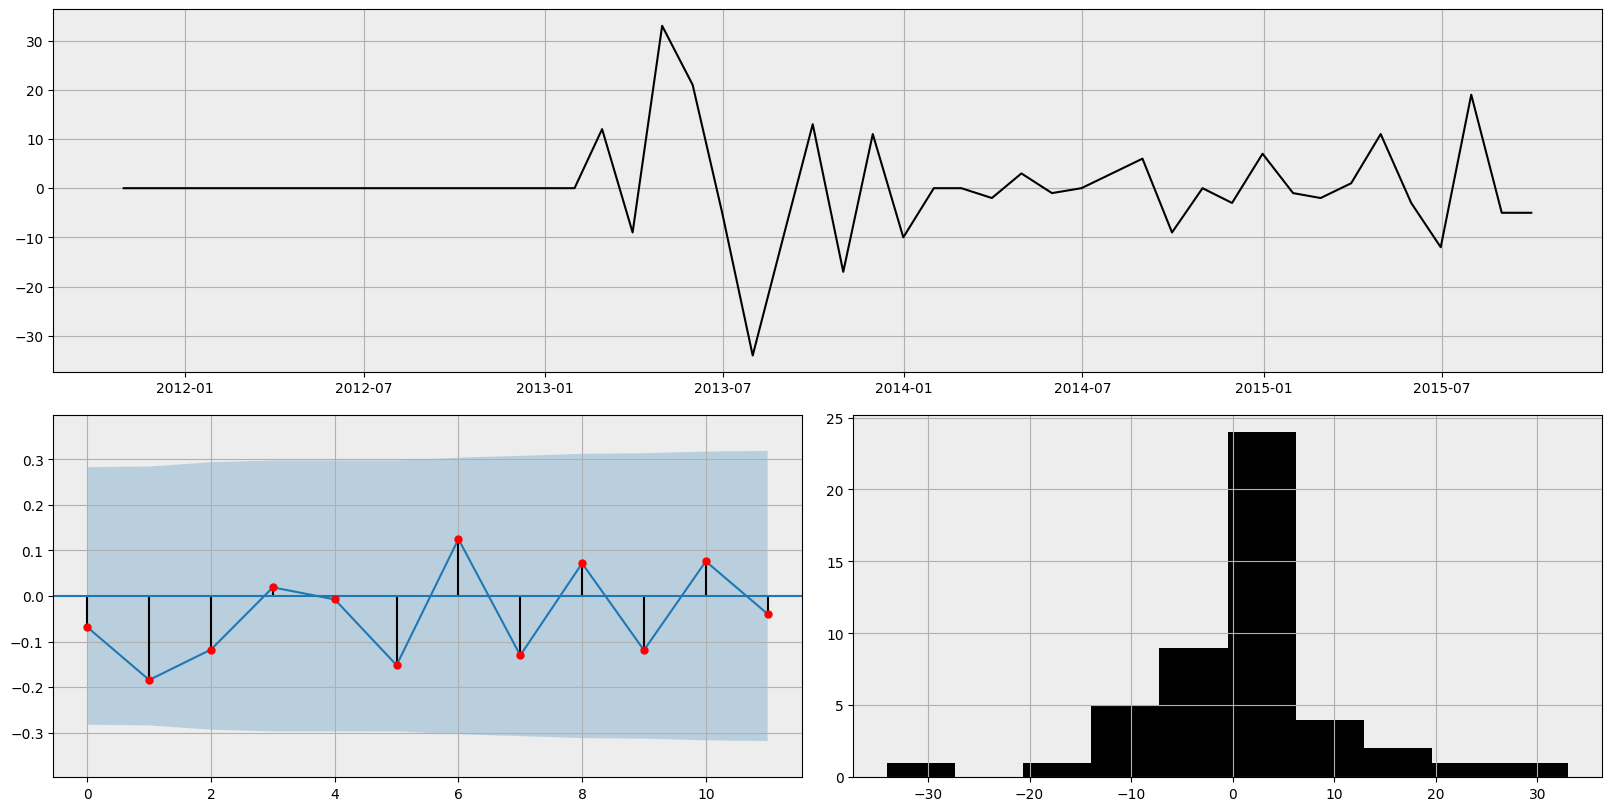

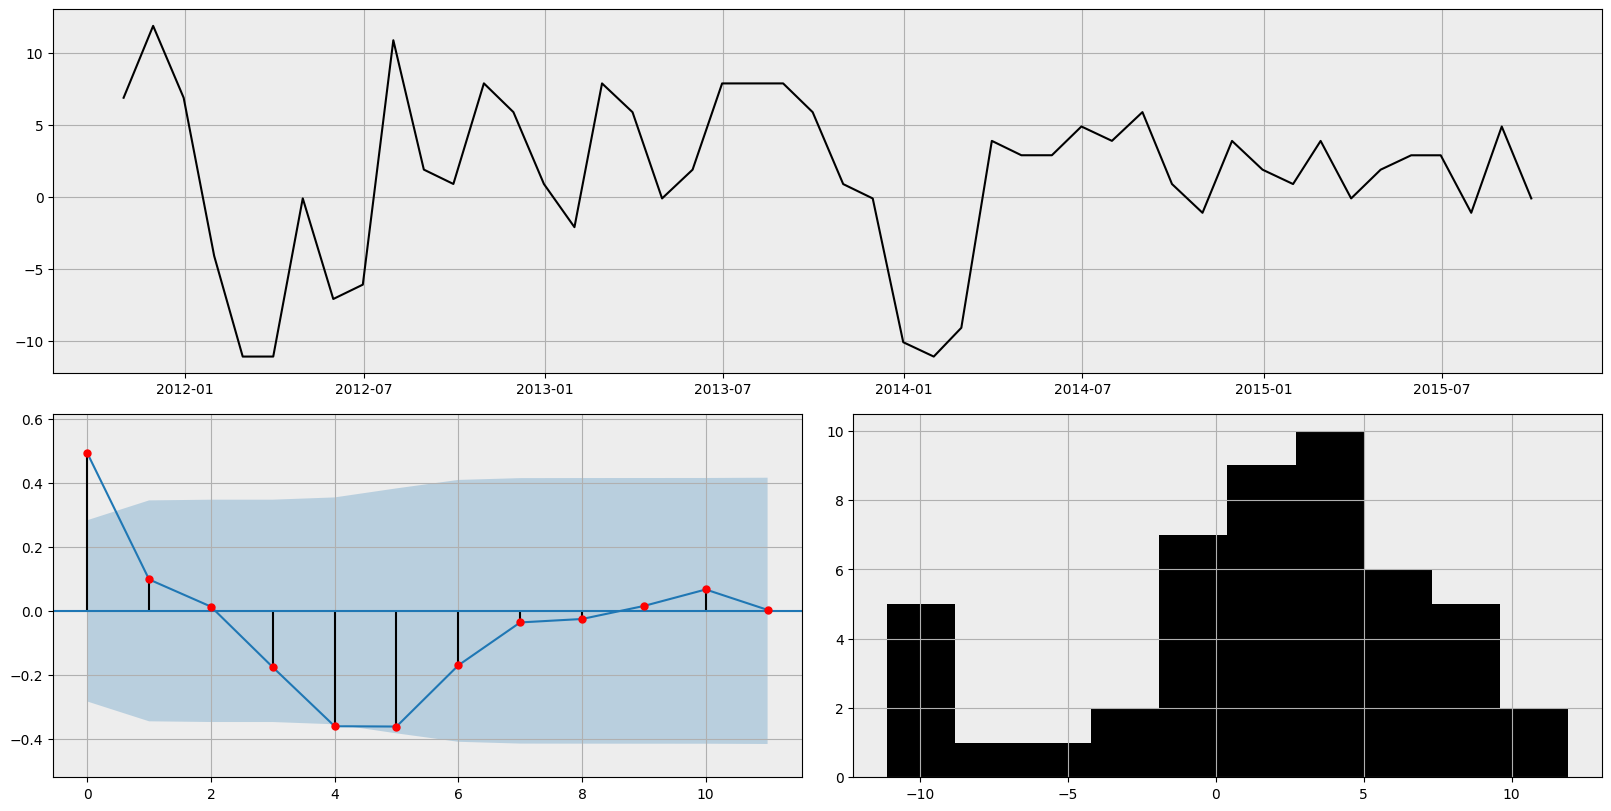

In [95]:
forecaster.residual_diagnosis(model = 'ETS', type = 'random', n = 3)

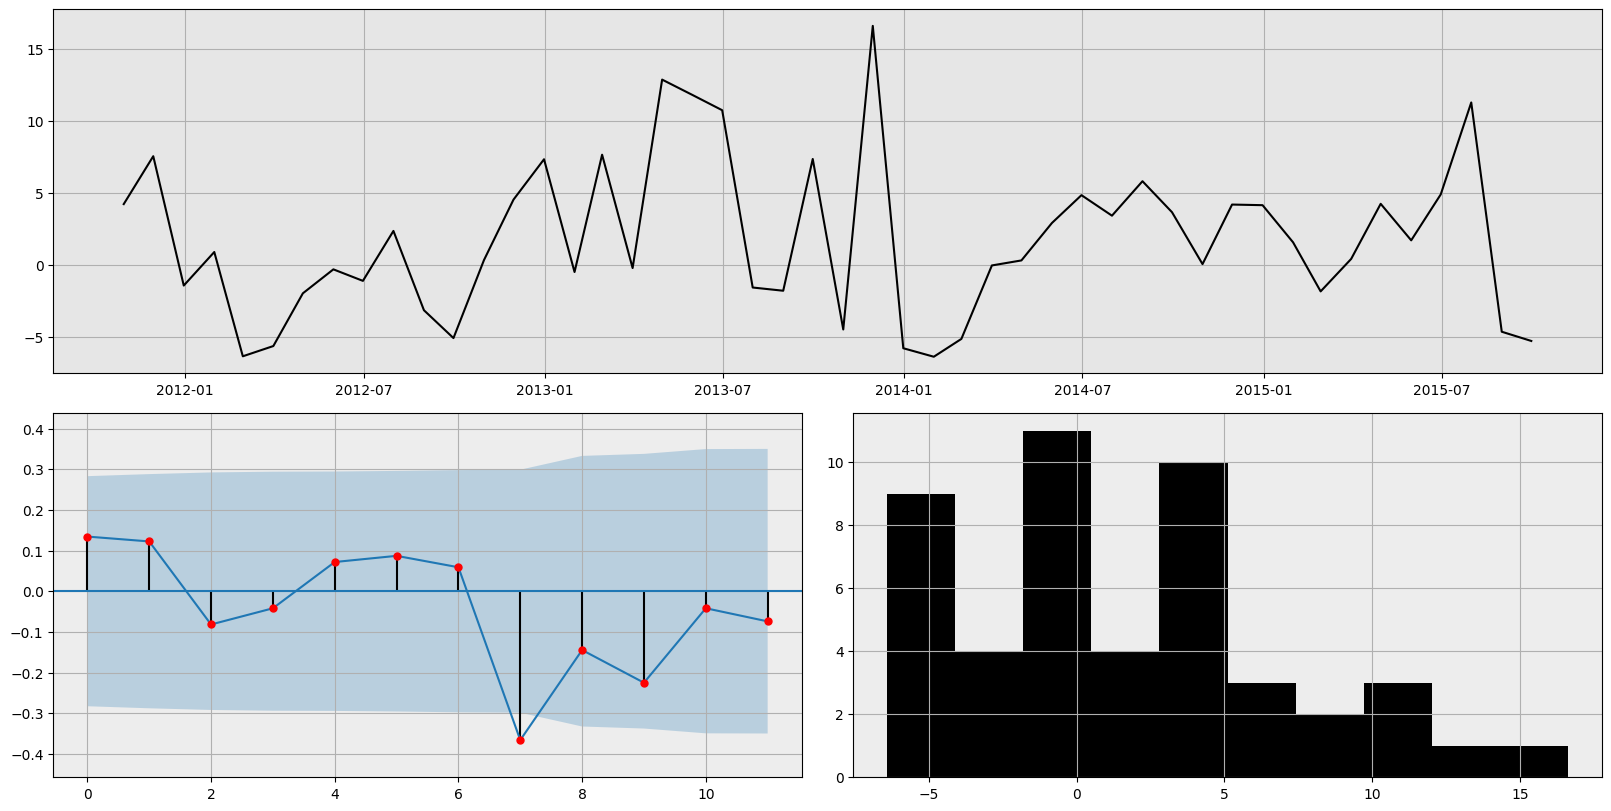

In [96]:
forecaster.residual_diagnosis(model = 'ETS', type = 'aggregate', agg_func = 'mean')

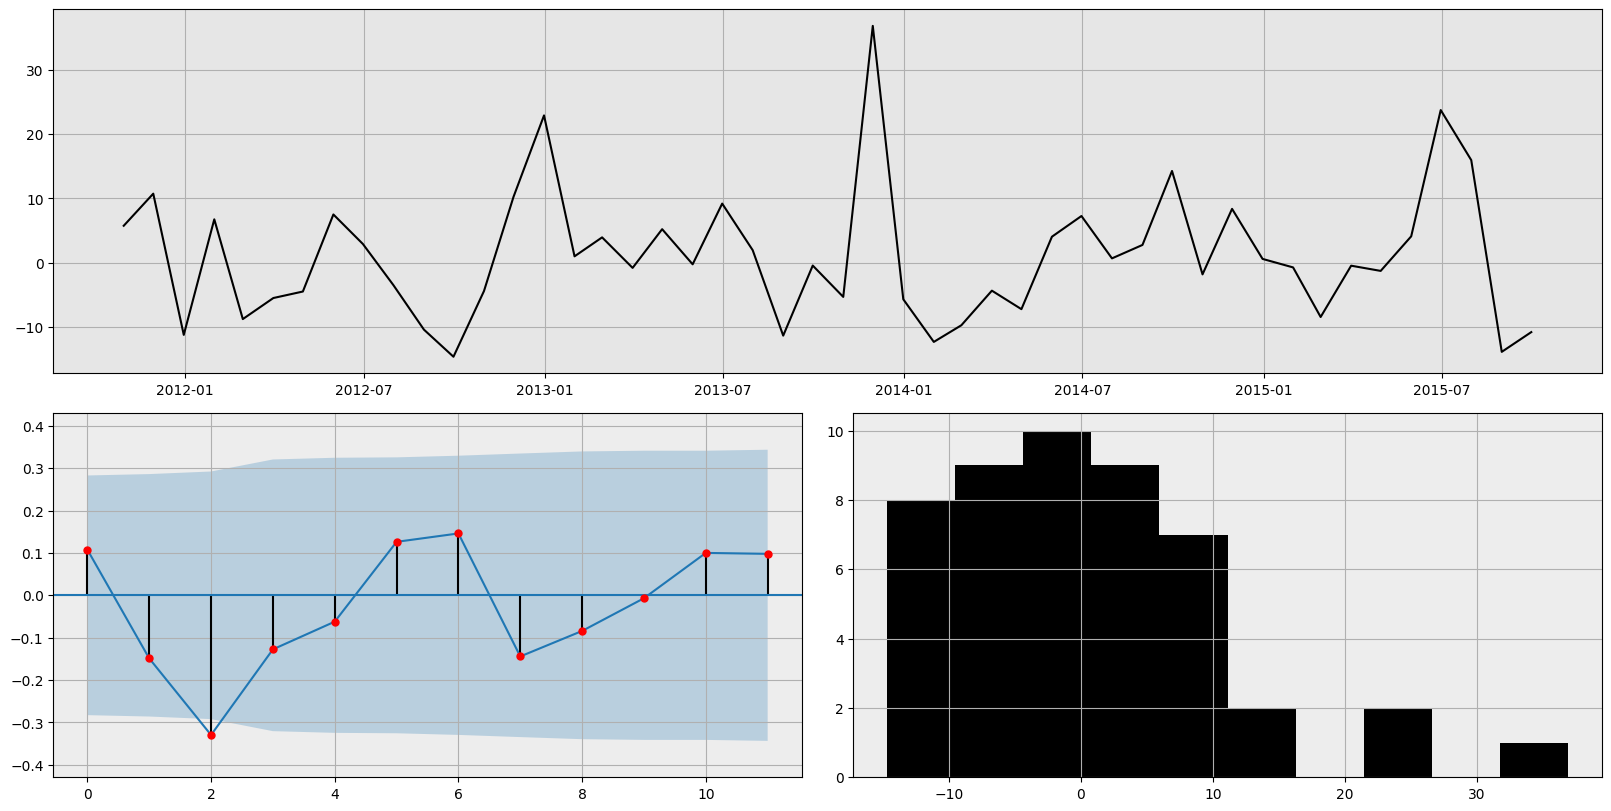

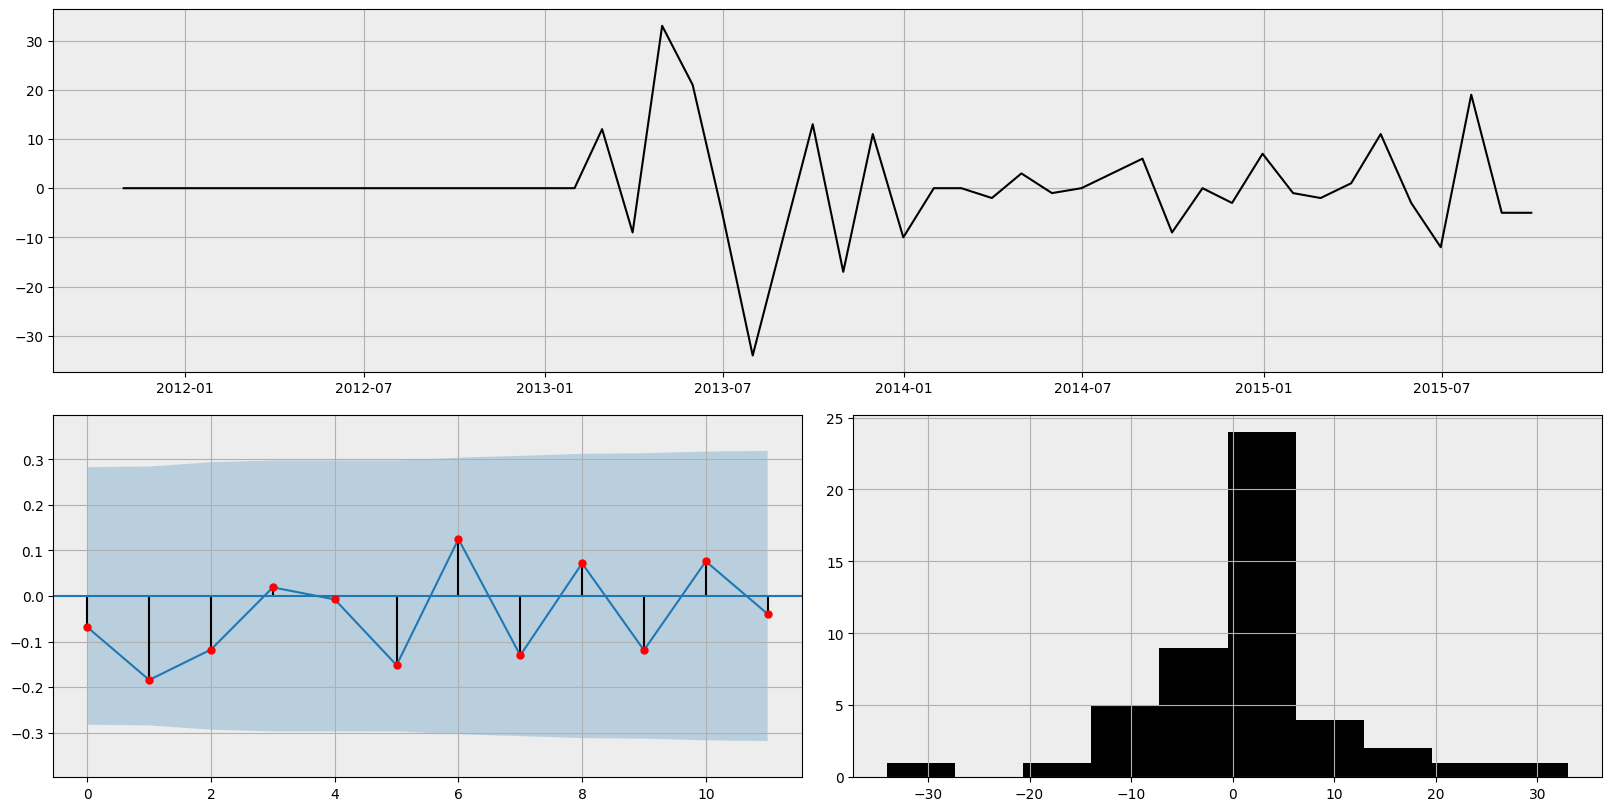

In [97]:
# Get the first two names
names = residuals['unique_id'].unique()[:2]
forecaster.residual_diagnosis(model = 'ETS', type = 'individual', index_ids = names)